<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name: SAL
-----

Student Names
----

1. Lisa Chua
2. Alaa A Latif
3. Shane Buchanan 

Load Data
-----

In [44]:
reset -fs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Functions used in the following code

In [2]:
def make_pipeline(classifier=None):
    "Create a single pipeline that processes the data and then fits the regressor." 
    
    numeric_features     = ['age', 'campaign', 'cons.price.idx', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx',
                            'euribor3m', 'nr.employed']
    categorical_features = ['job', 'education', 'default', 'housing',
                            'loan', 'campaign', 'poutcome', 'marital', 'contact', 'month', 'day_of_week']
    
    categorical_transformer = Pipeline(steps=[
    ('impute', impute.SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))])
    
    numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('scaler', preprocessing.StandardScaler())])
    
    
    
    preprocessor = compose.ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', classifier)])
    return pipeline

In [8]:
def up_sample(X, y):
    rows_idxs_no = y == 'no'
    rows_idxs_yes = y == 'yes'
    df_yes = pd.concat((X.loc[rows_idxs_yes], y.loc[rows_idxs_yes]), axis = 1)
    df_no = pd.concat((X.loc[rows_idxs_no], y.loc[rows_idxs_no]), axis = 1)
    df_yes_upsampled = df_yes.sample(int(len(df_yes)*5), replace=True)
    df_upsampled = pd.concat([df_no, df_yes_upsampled], axis=0)
    return df_upsampled.drop('y', axis=1), df_upsampled['y']

In [71]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Citation:
    Function from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Load in the data and create the X and y

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [4]:
t = (df.dtypes == 'object')
trues = [i for i, x in enumerate(t) if x][:-1]

In [5]:
# Features data.
X = df.drop('y', axis=1)

In [6]:
y = df['y']

### Create a test set to lock away and not touch until testing the final model

In [7]:
# Train-test-split on data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set baseline a priori score 

In [33]:
y_pred_no = pd.Series(['no' for _ in range(len(y_test))])

In [42]:
f1_score(y_test, y_pred_no, average='weighted')

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8410306658072104

In [43]:
accuracy_score(y_test, y_pred_no)

0.891964068948774

# K Fold Cross Validation

In [9]:
kf = KFold(n_splits=5, shuffle=True)

In [162]:
# Perform KFold cross validation using SMOTE to upsample
smt = SMOTENC(trues)
X_train_up, y_train_up = smt.fit_sample(X_train, y_train)
X_train_up = pd.DataFrame(X_train_up, columns=X.columns)
y_train_up = pd.Series(y_train_up)
for train_index, test_index in kf.split(X_train_up):
    X_train_up1, X_val_up = X_train_up.iloc[train_index], X_train_up.iloc[test_index]
    y_train_up1, y_val_up = y_train_up.iloc[train_index], y_train_up.iloc[test_index]
    #clf = DecisionTreeClassifier()
    #clf = LogisticRegression()
    clf = RandomForestClassifier(n_estimators=10)
    pipeline = make_pipeline(clf)
    pipeline.fit(X_train_up1, y_train_up1)
    y_pred = pipeline.predict(X_val_up)
    print(f1_score(y_val_up, y_pred, average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.906572445956427


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8966070372091789


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8976201423952234


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9030141942039259


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9056096536771221


In [10]:
# Peform KFold cross validation without upsampling
X_train_up = X_train
y_train_up = y_train
for train_index, test_index in kf.split(X_train_up):
    X_train_up1, X_val_up = X_train_up.iloc[train_index], X_train_up.iloc[test_index]
    y_train_up1, y_val_up = y_train_up.iloc[train_index], y_train_up.iloc[test_index]
    #clf = DecisionTreeClassifier()
    #clf = LogisticRegression()
    clf = RandomForestClassifier(n_estimators=10)
    pipeline = make_pipeline(clf)
    pipeline.fit(X_train_up1, y_train_up1)
    y_pred = pipeline.predict(X_val_up)
    print(f1_score(y_val_up, y_pred, average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8716609720067764


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8724270682265509


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8781068800497029


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8725716702018976


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.874796380798487


In [73]:
# Perform KFold cross validation using our upsampling function
X_train_up, y_train_up = up_sample(X_train, y_train)
X_train_up = pd.DataFrame(X_train_up, columns=X.columns)
y_train_up = pd.Series(y_train_up)
for train_index, test_index in kf.split(X_train_up):
    X_train_up1, X_val_up = X_train_up.iloc[train_index], X_train_up.iloc[test_index]
    y_train_up1, y_val_up = y_train_up.iloc[train_index], y_train_up.iloc[test_index]
    #clf = DecisionTreeClassifier()
    #clf = LogisticRegression()
    clf = RandomForestClassifier(n_estimators=10)
    pipeline = make_pipeline(clf)
    pipeline.fit(X_train_up1, y_train_up1)
    y_pred = pipeline.predict(X_val_up)
    print(f1_score(y_val_up, y_pred, average='weighted'))

0.9526296966281124
0.954855650844229
0.956940366941245
0.9545539027587276
0.9558304806751708


## Fit on all the training data and Predict the test set

In [11]:
pipeline.fit(X_train_up, y_train_up)
y_pred = pipeline.predict(X_test)

In [12]:
# delete this later but use for spot checking for now
confusion_matrix(y_test, y_pred)

array([[7110,  238],
       [ 638,  252]])

Evaluation Metric
----

In [13]:
# Use F1 score as metric since we have an unbalanced data set.
f1_score(y_test, y_pred, average='weighted')

0.8796612286515293

In [14]:
accuracy_score(y_test, y_pred)

0.8936635105608157

# Confusion Matrix

In [30]:
plt.rcParams["figure.figsize"] = (10,10)

Confusion matrix, without normalization
[[7110  238]
 [ 638  252]]
Normalized confusion matrix
[[0.97 0.03]
 [0.72 0.28]]


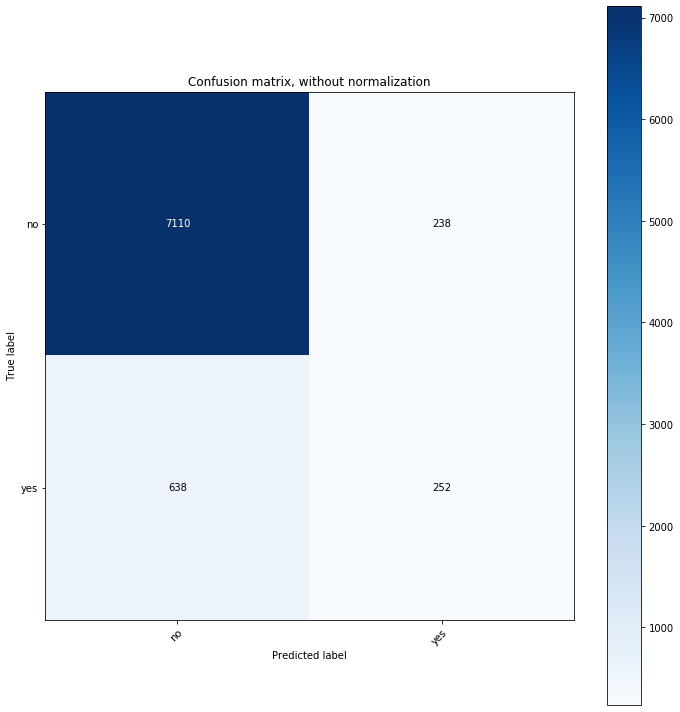

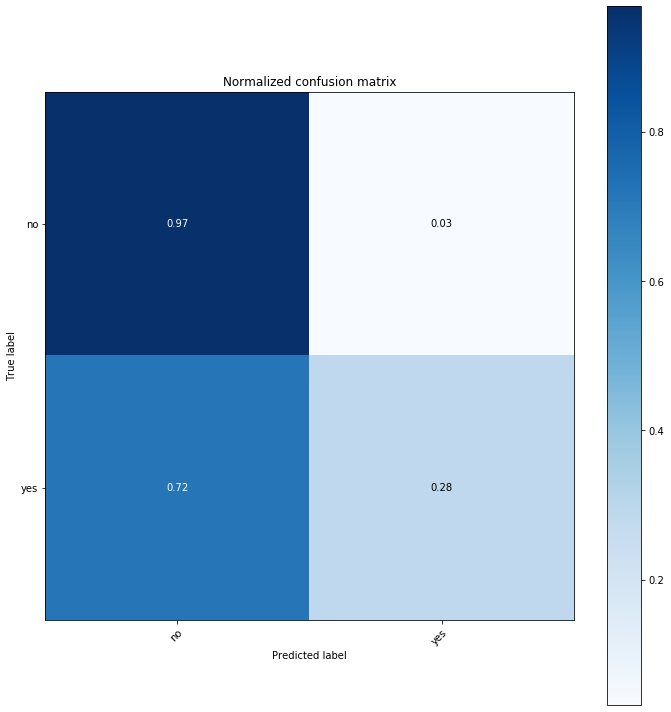

In [72]:
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

# Precision Recall Curve

In [49]:
y_test_binary = pd.Series(y_test).replace({'no': 0, 'yes': 1})
y_pred_binary = pd.Series(y_pred).replace({'no': 0, 'yes': 1})

In [59]:
from inspect import signature

In [88]:
lr_probs = pipeline.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

Logistic: f1=0.880 auc=0.353


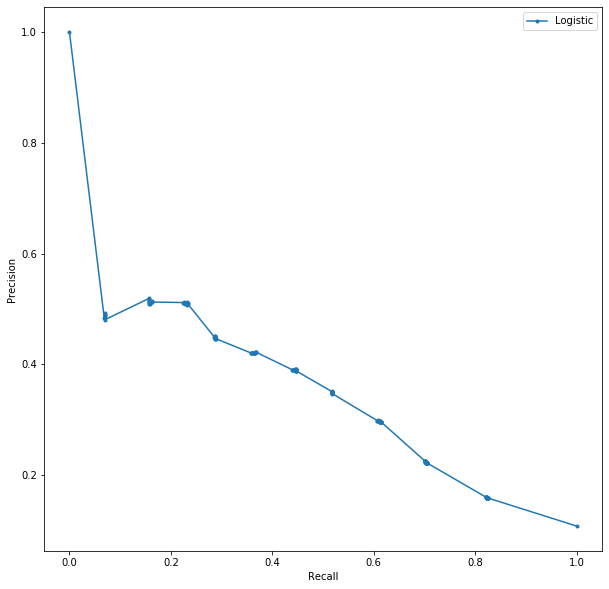

In [89]:
yhat = y_pred_binary
lr_precision, lr_recall, _ = precision_recall_curve(y_test_binary, lr_probs)
lr_f1, lr_auc = f1_score(y_test_binary, yhat, average='weighted'), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()